In [46]:
import pandas as pd
import numpy as np
import random
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [47]:
df = pd.read_csv('2918001_JEQUIE.csv', sep=';', dtype=str)

In [48]:
df_aux = df[['NOM_TIPO_SEGLOGR', 'NOM_SEGLOGR', 'NUM_ENDERECO']]
df_aux = df_aux.sample(n=1000, random_state=42)

In [49]:
df_aux

,NOM_TIPO_SEGLOGR,NOM_SEGLOGR,NUM_ENDERECO
64999,RUA,CEARA,9
83099,AVENIDA,RIO BRANCO,533
85853,ESTRADA,ITAJI JITAUNA,0
71597,RUA,EDEVALDO NETO,3
8790,RUA,SEM DENOMINACAO 19,15
...,...,...,...
47179,TRAVESSA,ITUACU,16
50664,TRAVESSA,LANDUFO CARIBE,103
16787,BOQUEIRAO,ITAJURU,0
69028,RUA,2 DE JULHO,0


In [50]:
def introduzir_erros_df_aux(df, proporcao_erros=1.0):
    df_corrupto = df.copy()
    num_erros = int(len(df) * proporcao_erros)

    for _ in range(num_erros):
        idx = random.randint(0, len(df) - 1)
        erro_tipo = random.randint(1, 5)

        if erro_tipo == 1:
            df_corrupto.iloc[idx, df_corrupto.columns.get_loc("NOM_SEGLOGR")] = " ".join(
                str(df.iloc[idx]["NOM_SEGLOGR"]).split()[:-1])
        elif erro_tipo == 2:
            df_corrupto.iloc[idx, df_corrupto.columns.get_loc("NOM_TIPO_SEGLOGR")] = " "
        elif erro_tipo == 3:
            valor = str(df.iloc[idx]["NOM_SEGLOGR"])
            if len(valor) > 0:
                df_corrupto.iloc[idx, df_corrupto.columns.get_loc("NOM_SEGLOGR")] = \
                    valor[0].replace("W", "V") + valor[1:]
        elif erro_tipo == 4:
            df_corrupto.iloc[idx, df_corrupto.columns.get_loc("NUM_ENDERECO")] = " "
        elif erro_tipo == 5:
            valor = df.iloc[idx]["NUM_ENDERECO"]
            if not pd.isnull(valor):
                df_corrupto.iloc[idx, df_corrupto.columns.get_loc("NUM_ENDERECO")] = valor

    return df_corrupto


In [51]:
df_para_erro = df_aux.sample(n=20, random_state=42)

In [52]:
df_corrupto = introduzir_erros_df_aux(df_para_erro)
df_corrupto

,NOM_TIPO_SEGLOGR,NOM_SEGLOGR,NUM_ENDERECO
86923,RUA,BOA,17
37119,ESTRADA,PARA O ATANAZIO VIA FLORESTAL,320
63525,ESTRADA,PARA JEQUIE,
43754,RUA,FLORES DO CAMPO,212
52466,,BEIRA RIO,8
980,RUA,WASHINGTON NAVARRO PINTO,
27748,,MIGUEL GOMES DA SILVA,227
65044,,JOSE GONCALVES PEREIRA,127
58152,,CARLOS,403
47621,AVENIDA,NAZARE,746


In [53]:
df_corrupto['endereco_completo_corrupto'] = df_corrupto.apply(
    lambda row: f"{row['NOM_TIPO_SEGLOGR']} {row['NOM_SEGLOGR']} {row['NUM_ENDERECO']}", axis=1
)
df_aux['endereco_completo'] = df_aux.apply(
    lambda row: f"{row['NOM_TIPO_SEGLOGR']} {row['NOM_SEGLOGR']} {row['NUM_ENDERECO']}", axis=1
)
df_corrupto['endereco_completo_corrupto']

86923                                   RUA BOA 17
37119    ESTRADA PARA O ATANAZIO VIA FLORESTAL 320
63525                        ESTRADA PARA JEQUIE  
43754                      RUA FLORES DO CAMPO 212
52466                                  BEIRA RIO 8
980                 RUA WASHINGTON NAVARRO PINTO  
27748                    MIGUEL GOMES DA SILVA 227
65044                   JOSE GONCALVES PEREIRA 127
58152                                   CARLOS 403
47621                           AVENIDA NAZARE 746
56077                 TRAVESSA SEGUNDA EVERALDO 49
14791                  TRAVESSA ANIBAL DOS ANJOS 1
86254                           RUA DA PAROQUIA 11
77478                                   FRANZ 1231
79154                           RUA ALVES CABRAL 8
51418                     RUA SEM DENOMINACAO 13 0
85945                            RODOVIA BR 116 70
67355                                RUA GOIAS 621
50206                    RUA SEM DENOMINACAO 19 21
18592                          

In [54]:
# 📌 Geração de embeddings com BERT

df_novo = pd.DataFrame()

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

df_corrupto["embedding_nome"] = df_corrupto["endereco_completo_corrupto"].apply(lambda x: get_bert_embedding(x) if pd.notnull(x) else np.zeros(768))
df_aux["embedding_nome"] = df_aux["endereco_completo"].apply(lambda x: get_bert_embedding(x) if pd.notnull(x) else np.zeros(768))

In [70]:
# Aplicando PCA
scaler = StandardScaler()
X = np.stack(df_corrupto["embedding_nome"].values)
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=4)
df_corrupto["pca_embedding"] = list(
    (pca.fit_transform(X_scaled / np.linalg.norm(X_scaled, axis=1, keepdims=True)) - np.min(X_scaled)) / 
    (np.max(X_scaled) - np.min(X_scaled))
)

In [69]:
# Aplicando PCA
scaler = StandardScaler()
X = np.stack(df_aux["embedding_nome"].values)
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=4)
df_aux["pca_embedding"] = list(
    (pca.fit_transform(X_scaled / np.linalg.norm(X_scaled, axis=1, keepdims=True)) - np.min(X_scaled)) / 
    (np.max(X_scaled) - np.min(X_scaled))
)

In [71]:
df_corrupto

,NOM_TIPO_SEGLOGR,NOM_SEGLOGR,NUM_ENDERECO,endereco_completo_corrupto,embedding_nome,pca_embedding
86923,RUA,BOA,17,RUA BOA 17,"[-0.11782217, 0.18238942, -0.16508839, -0.4755...","[0.5104891, 0.5110229, 0.4410245, 0.42446947]"
37119,ESTRADA,PARA O ATANAZIO VIA FLORESTAL,320,ESTRADA PARA O ATANAZIO VIA FLORESTAL 320,"[0.12061361, -0.1731273, 0.29007217, 0.0545298...","[0.42815477, 0.41898346, 0.51256204, 0.467112]"
63525,ESTRADA,PARA JEQUIE,,ESTRADA PARA JEQUIE,"[0.2073119, -0.33932, -0.0077000773, 0.2901097...","[0.4152496, 0.45977542, 0.46919206, 0.46536562]"
43754,RUA,FLORES DO CAMPO,212,RUA FLORES DO CAMPO 212,"[0.064686544, 0.08772722, -0.013971452, -0.385...","[0.55359006, 0.49483487, 0.51775056, 0.46050698]"
52466,,BEIRA RIO,8,BEIRA RIO 8,"[-0.28325042, 0.10287878, -0.10414377, -0.2890...","[0.51347864, 0.53365767, 0.45422044, 0.43103504]"
980,RUA,WASHINGTON NAVARRO PINTO,,RUA WASHINGTON NAVARRO PINTO,"[0.021642327, -0.19775918, -0.5363429, -0.0927...","[0.41967312, 0.5275409, 0.4857386, 0.471624]"
27748,,MIGUEL GOMES DA SILVA,227,MIGUEL GOMES DA SILVA 227,"[-0.30853426, -0.10216552, 0.14427081, -0.2908...","[0.55635226, 0.56782407, 0.4791981, 0.53236693]"
65044,,JOSE GONCALVES PEREIRA,127,JOSE GONCALVES PEREIRA 127,"[0.2901055, 0.11744626, 0.12539956, -0.0792219...","[0.57002026, 0.52712315, 0.4967599, 0.5617265]"
58152,,CARLOS,403,CARLOS 403,"[0.12848623, -0.06634581, -0.084763765, 0.0016...","[0.39098912, 0.5434822, 0.4450922, 0.5257103]"
47621,AVENIDA,NAZARE,746,AVENIDA NAZARE 746,"[0.20681925, -0.2264405, 0.36601532, -0.253524...","[0.45200545, 0.47137785, 0.5955398, 0.4997681]"


In [72]:
df_aux

,NOM_TIPO_SEGLOGR,NOM_SEGLOGR,NUM_ENDERECO,endereco_completo,embedding_nome,pca_embedding
64999,RUA,CEARA,9,RUA CEARA 9,"[-0.15727529, 0.12644473, -0.3256037, -0.37599...","[0.49554947, 0.4750986, 0.5174128, 0.4898448]"
83099,AVENIDA,RIO BRANCO,533,AVENIDA RIO BRANCO 533,"[0.136259, 0.06280725, -0.061914258, -0.197512...","[0.49631193, 0.56224406, 0.54277796, 0.4919055]"
85853,ESTRADA,ITAJI JITAUNA,0,ESTRADA ITAJI JITAUNA 0,"[-0.46304744, -0.12710127, 0.12897253, -0.0792...","[0.5536396, 0.510944, 0.5397801, 0.52208316]"
71597,RUA,EDEVALDO NETO,3,RUA EDEVALDO NETO 3,"[-0.30294582, -0.20964314, 0.17850019, -0.4032...","[0.45456335, 0.51418096, 0.52319723, 0.50703704]"
8790,RUA,SEM DENOMINACAO 19,15,RUA SEM DENOMINACAO 19 15,"[-0.4115404, -0.039674934, -0.03653646, -0.183...","[0.4957112, 0.5032509, 0.5349596, 0.5914649]"
...,...,...,...,...,...,...
47179,TRAVESSA,ITUACU,16,TRAVESSA ITUACU 16,"[-0.33619705, 0.24266624, -0.2331952, -0.02059...","[0.5574802, 0.50893813, 0.53001416, 0.52549815]"
50664,TRAVESSA,LANDUFO CARIBE,103,TRAVESSA LANDUFO CARIBE 103,"[-0.05596342, 0.12422915, -0.0404359, -0.02222...","[0.54911846, 0.5316286, 0.5249723, 0.55748725]"
16787,BOQUEIRAO,ITAJURU,0,BOQUEIRAO ITAJURU 0,"[-0.5853739, 0.131958, -0.14857203, -0.1600257...","[0.5030782, 0.49556646, 0.54800886, 0.5134179]"
69028,RUA,2 DE JULHO,0,RUA 2 DE JULHO 0,"[-0.46527815, -0.44437277, 0.24178842, -0.1781...","[0.504638, 0.50176, 0.52950287, 0.51977205]"


In [66]:
min_value = max(max(sublist) for sublist in df_aux['pca_embedding'])
print(min_value)

0.7892314


In [73]:
np.save('data/pca_embedding_corrupto.npy', np.array(df_corrupto['pca_embedding'].tolist()))
np.save('data/4d_uniform_data_0.npy', np.array(df_aux['pca_embedding'].tolist()))
np.save('data/4d_uniform_data_1.npy', np.array(df_aux['pca_embedding'].tolist()))
np.save('data/4d_uniform_data_2.npy', np.array(df_aux['pca_embedding'].tolist()))
np.save('data/4d_uniform_data_3.npy', np.array(df_aux['pca_embedding'].tolist()))

In [60]:
np.load('data/4d_uniform_data_0.npy')

array([[-0.22166179, -0.43356565,  0.00487487, -0.2807722 ],
       [-0.2137617 ,  0.46939963,  0.2676997 , -0.2594184 ],
       [ 0.38024428, -0.06215006,  0.2366368 ,  0.05326756],
       ...,
       [-0.14365242, -0.22148597,  0.3219005 , -0.03651657],
       [-0.12749061, -0.1573111 ,  0.13014881,  0.02932027],
       [ 0.67251134, -0.48624104,  0.02769473, -0.09289013]],
      dtype=float32)

In [67]:
import numpy as np

def format_queries_to_qr(array_2d, delta=0.001):
    """
    Recebe um np.array (n, 2) e retorna uma string formatada com queries 2D (8 valores) no padrão .qr.
    """
    lines = []
    i = 0
    for row in array_2d:
        query_line = []
        for val in row:
            query_line.extend([val - delta, val + delta])
        query_line_str = ', '.join(f"{x:.9f}" for x in query_line)
        lines.append(f"# Query range 2D {i}\n" + query_line_str)
        i+=1
    return '\n\n'.join(lines)

def salvar_queries_em_arquivo(array_2d, caminho_arquivo="2d_uniform_query_ranges.qr", delta=0.001):
    """
    Gera e salva o conteúdo de queries 2D em um arquivo de texto.
    """
    conteudo = format_queries_to_qr(array_2d, delta)
    with open(caminho_arquivo, "w") as f:
        f.write(conteudo)
    print(f"Arquivo salvo em: {caminho_arquivo}")

# Exemplo de uso
array_exemplo = np.load('data/pca_embedding_corrupto.npy')

salvar_queries_em_arquivo(array_exemplo, "data/4d_uniform_query_ranges.qr", delta=0.0001)


Arquivo salvo em: data/4d_uniform_query_ranges.qr


In [62]:
indexes_corruptos = df_corrupto.index.tolist()

df_aux.loc[indexes_corruptos].assign(Contador=range(1, len(indexes_corruptos) + 1))

,NOM_TIPO_SEGLOGR,NOM_SEGLOGR,NUM_ENDERECO,endereco_completo,embedding_nome,pca_embedding,Contador
86923,RUA,BOA VISTA,17,RUA BOA VISTA 17,"[-0.3521758, 0.01850103, -0.092250556, -0.3955...","[-0.24674243, -0.18618174, -0.18186504, -0.082...",1
37119,ESTRADA,PARA O ATANAZIO VIA FLORESTAL,320,ESTRADA PARA O ATANAZIO VIA FLORESTAL 320,"[0.12061361, -0.1731273, 0.29007217, 0.0545298...","[0.38817206, 0.27512747, 0.22281429, 0.16628906]",2
63525,ESTRADA,PARA JEQUIE,760,ESTRADA PARA JEQUIE 760,"[0.26793122, -0.15207933, 0.20706198, 0.213139...","[0.47406778, 0.21476373, 0.16394338, 0.054769915]",3
43754,RUA,FLORES DO CAMPO,212,RUA FLORES DO CAMPO 212,"[0.064686544, 0.08772722, -0.013971452, -0.385...","[-0.30012393, 0.06653508, -0.31185398, -0.0891...",4
52466,RUA,BEIRA RIO,8,RUA BEIRA RIO 8,"[-0.1411114, -0.025901947, 0.007404562, -0.298...","[-0.3405672, -0.17610042, -0.15119909, -0.3068...",5
980,RUA,WASHINGTON NAVARRO PINTO,6,RUA WASHINGTON NAVARRO PINTO 6,"[-0.08004066, -0.013050662, -0.24713856, 0.078...","[0.4059864, -0.1757265, 0.0025690035, -0.07837...",6
27748,RUA,MIGUEL GOMES DA SILVA,227,RUA MIGUEL GOMES DA SILVA 227,"[-0.48177272, -0.23304078, 0.06568754, -0.3576...","[-0.4885154, -0.025433484, -0.2931986, -0.0033...",7
65044,RUA,JOSE GONCALVES PEREIRA,127,RUA JOSE GONCALVES PEREIRA 127,"[0.1364986, -0.006638783, 0.18494228, -0.23276...","[-0.57083154, 0.01882944, -0.18185028, 0.00780...",8
58152,RUA,CARLOS AGUIAR,403,RUA CARLOS AGUIAR 403,"[-0.06737968, -0.27252394, -0.11003152, -0.483...","[0.3390045, 0.31970719, -0.36756805, 0.007148807]",9
47621,AVENIDA,NAZARE,746,AVENIDA NAZARE 746,"[0.20681925, -0.2264405, 0.36601532, -0.253524...","[0.36236048, 0.5999175, 0.08595557, -0.09661429]",10


[[-12.693949, 2.5960326, -12.982247, 2.62079], [-12.693949, 2.5960326, -12.982247, 2.62079]]


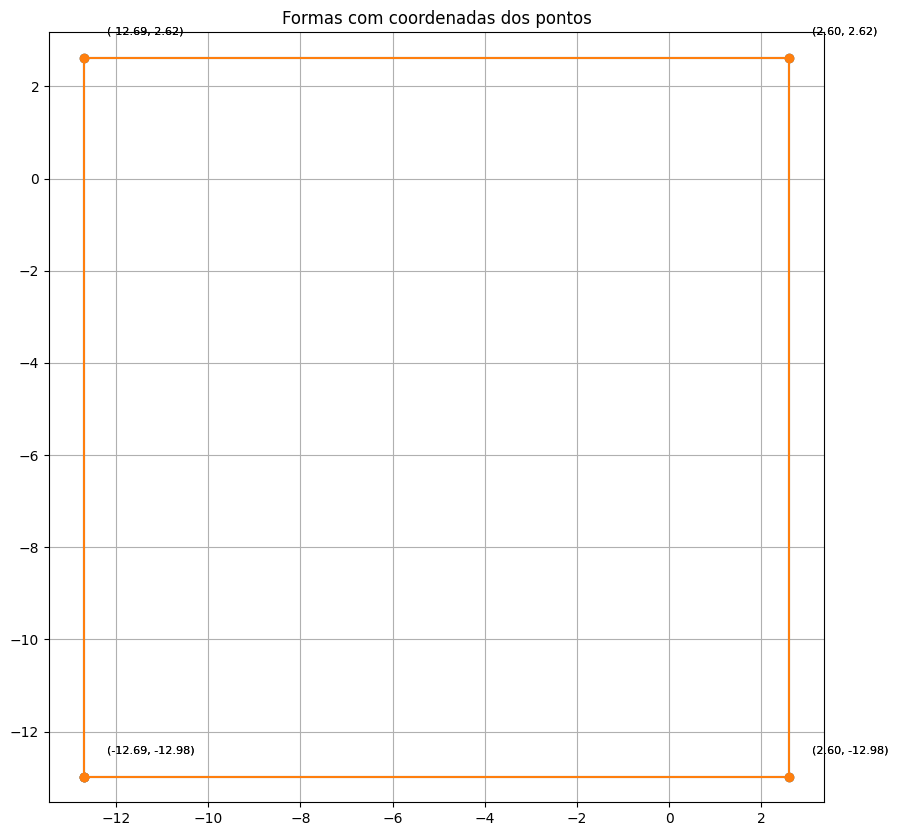

In [63]:

import matplotlib.pyplot as plt

# Dados extraídos da imagem
# arrays = df_aux.loc[indexes_corruptos]['pca_embedding'].apply(lambda x: list(map(float, x))).tolist()
arrays = [[-12.693949, 2.5960326, -12.982247, 2.62079],
          [-12.693949, 2.5960326, -12.982247, 2.62079]]

print(arrays)

plt.figure(figsize=(10, 10))

for i, arr in enumerate(arrays):
    x1, x2, y1, y2 = arr
    # Canto inferior esquerdo, inferior direito, superior direito, superior esquerdo
    x = [x1, x2, x2, x1, x1]
    y = [y1, y1, y2, y2, y1]

    # Plotando a forma
    plt.plot(x, y, marker='o', label=f'Valor {i+1}')
    
    # Adicionando coordenadas nos pontos
    for j in range(4):
        label = f'({x[j]:.2f}, {y[j]:.2f})'
        plt.text(x[j] + 0.5, y[j] + 0.5, label, fontsize=8, color='black')

plt.title('Formas com coordenadas dos pontos')
# plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()



[[0.12174774706363678, 0.12560275197029114, -0.3437105715274811, -0.45437783002853394], [-0.4297926127910614, -0.49112486839294434, 0.1354374885559082, -0.17002160847187042], [-0.516253650188446, -0.21817448735237122, -0.15466658771038055, -0.17942693829536438], [0.41046929359436035, 0.017093908041715622, 0.17050115764141083, -0.21175161004066467], [0.14175251126289368, 0.2764393985271454, -0.25512683391571045, -0.41091108322143555], [-0.48661574721336365, 0.23561060428619385, -0.044411201030015945, -0.13962078094482422], [0.42900311946868896, 0.5060091614723206, -0.08788328617811203, 0.2675594091415405], [0.5205115079879761, 0.23293066024780273, 0.029425306245684624, 0.4652642607688904], [-0.6787592768669128, 0.34313225746154785, -0.3162144422531128, 0.22430312633514404], [-0.270011842250824, -0.14012113213539124, 0.6915480494499207, 0.04963390901684761], [-0.5842247605323792, -0.1783250868320465, 0.163093701004982, -0.12211591005325317], [0.3630777895450592, -0.08513253182172775, 0.0

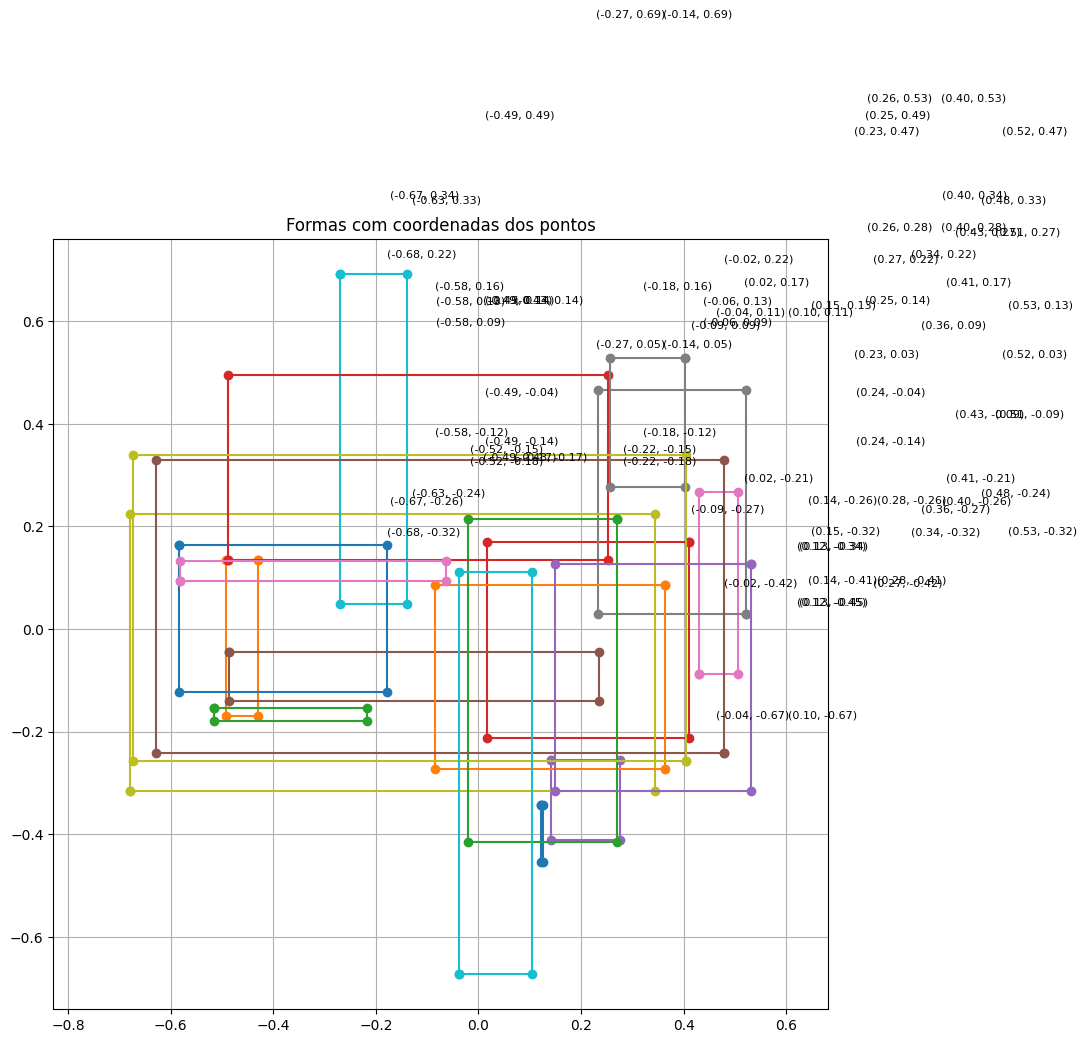

In [64]:

import matplotlib.pyplot as plt

# Dados extraídos da imagem
arrays = df_corrupto['pca_embedding'].apply(lambda x: list(map(float, x))).tolist()

print(arrays)

plt.figure(figsize=(10, 10))

for i, arr in enumerate(arrays):
    x1, x2, y1, y2 = arr
    # Canto inferior esquerdo, inferior direito, superior direito, superior esquerdo
    x = [x1, x2, x2, x1, x1]
    y = [y1, y1, y2, y2, y1]

    # Plotando a forma
    plt.plot(x, y, marker='o', label=f'Valor {i+1}')
    
    # Adicionando coordenadas nos pontos
    for j in range(4):
        label = f'({x[j]:.2f}, {y[j]:.2f})'
        plt.text(x[j] + 0.5, y[j] + 0.5, label, fontsize=8, color='black')

plt.title('Formas com coordenadas dos pontos')
# plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()



In [68]:
import matplotlib.pyplot as plt
import itertools
import os

# Gera combinações únicas de cor e estilo de linha
cores = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']
linestyles = ['-', '--', '-.', ':']
estilos = list(itertools.product(cores, linestyles))

# Garante que a pasta plots exista
os.makedirs('plots', exist_ok=True)

# Itera pelas linhas dos dois DataFrames
for i, ((idx1, row1), (idx2, row2)) in enumerate(zip(df_aux.loc[indexes_corruptos].iterrows(), df_corrupto.iterrows())):
    # Extrai e converte os dados
    arr1 = list(map(float, row1['pca_embedding']))  # DF original
    arr2 = list(map(float, row2['pca_embedding']))  # DF corrompido

    cor, _ = estilos[i % len(estilos)]  # Mesma cor para facilitar comparação

    # Cria o gráfico
    plt.figure(figsize=(6, 6))

    # --- Forma original (DF1) ---
    x1, x2, y1, y2 = arr1
    x_orig = [x1, x2, x2, x1, x1]
    y_orig = [y1, y1, y2, y2, y1]
    plt.plot(x_orig, y_orig, marker='o', color=cor, linestyle='-', label='Original (DF1)')

    # Adiciona coordenadas da forma original
    for j in range(4):
        label = f'O({x_orig[j]:.2f}, {y_orig[j]:.2f})'
        plt.text(x_orig[j] + 0.5, y_orig[j] + 0.5, label, fontsize=8, color='black')

    # --- Forma corrompida (DF2) ---
    x1, x2, y1, y2 = arr2
    x_corr = [x1, x2, x2, x1, x1]
    y_corr = [y1, y1, y2, y2, y1]
    plt.plot(x_corr, y_corr, marker='x', color=cor, linestyle='--', label='Corrompido (DF2)')

    # Adiciona coordenadas da forma corrompida
    for j in range(4):
        label = f'C({x_corr[j]:.2f}, {y_corr[j]:.2f})'
        plt.text(x_corr[j] + 0.5, y_corr[j] - 0.5, label, fontsize=8, color='gray')

    plt.title(f'Comparação Forma {i+1}')
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.savefig(f'plots/plots_{i}.png')
    plt.close()
